## Plant Disesase Detection Inception V3 using Keras

**Install tensorflow-gpu for faster ML computations**

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 5.6 MB 50.1 MB/s 
     |████████████████████████████████| 4.3 MB 61.4 MB/s 
     |████████████████████████████████| 1.3 MB 50.6 MB/s 
     |████████████████████████████████| 462 kB 55.7 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha256=c31e4f276082398fdecfe710d9152dc4f07669b6cae60ae7fc706ba3589e23fa
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
Successfully built clang
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: 

In [ ]:
from tensorflow.compat.v1 import ConfigProto # for session configuration
from tensorflow.compat.v1 import InteractiveSession # default session for easy runtime execution

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
# import the libraries as shown below
# tensorflow.keras is used for high level deep learning predictions with simpler execution
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF

import cv2
import glob
import matplotlib.pyplot as plt
from os.path import splitext,basename

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# all of the photographs should be resized to this size
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Computer_Vision/Apple_Leaf_Disease_Detection_DS/train'
valid_path = '/content/drive/MyDrive/Computer_Vision/Apple_Leaf_Disease_Detection_DS/valid'
test_path = '/content/drive/MyDrive/Computer_Vision/Apple_Leaf_Disease_Detection_DS/test'


Mounted at /content/drive


In [ ]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

In [ ]:
# Import the Inception V3 library as shown below and add preprocessing layer to the front of Inception
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
# Not to train existing weights
for layer in inception.layers:
    layer.trainable = False

In [ ]:
# For number of output classes
folders = glob('/content/drive/MyDrive/Computer_Vision/Apple_Leaf_Disease_Detection_DS/train/*')

In [ ]:
# converts the pooled feature map to a single column that is passed to the fully connected layer
x = Flatten()(inception.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# Summary of the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Defining cost and optimization method for model training
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
# Importing images from dataset folders
# augment your images in real-time while your model is still training

# horizontal_flip : horizontal_flip and for flipping along the the horizontal axis.
# zoom_range : zoom will be done in the range [1-zoom_range,1+zoom_range] | value smaller than 1 will zoom in | value greater than 1 will zoom out
# shear_range : Shear angle in counter-clockwise direction in degrees
# rescale : multiply the data by the value provided after applying all other transformations

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# flow_from_directory() Method allows you to read the images directly from the directory and augment them while the neural network model
# batch_size : Size of the batches of data. Default: 32.


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 7736 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 27 images belonging to 1 classes.


In [ ]:
valid_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 15 images belonging to 4 classes.


In [52]:
# fitting the model
# epochs : Number of times we want to train our model
# steps_per_epoch : total number of steps taken from the generator as soon as one epoch is finished and next epoch has started
# validation_steps : total number of steps taken from the generator before it is stopped at every epoch

r = model.fit_generator(
  training_set,
  validation_data=valid_set,
  epochs=3,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
242/242 [==============================] - 731s 3s/step - loss: 0.2562 - accuracy: 0.9611 - val_loss: 5.8939e-05 - val_accuracy: 1.0000
Epoch 2/3
242/242 [==============================] - 731s 3s/step - loss: 0.3010 - accuracy: 0.9577 - val_loss: 0.4103 - val_accuracy: 0.9333
Epoch 3/3
242/242 [==============================] - 728s 3s/step - loss: 0.2793 - accuracy: 0.9641 - val_loss: 0.0652 - val_accuracy: 0.9333


In [ ]:
model.save('/content/drive/MyDrive/Computer_Vision/Model/model_inception.h5') # locally save inception model

In [ ]:
# Order to save computation over and over again , model is saved
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Computer_Vision/Model/model_inception.h5')

**Note**: **We have implemented the model for only 3 epochs in this particular notebook to avoid high processing times.**

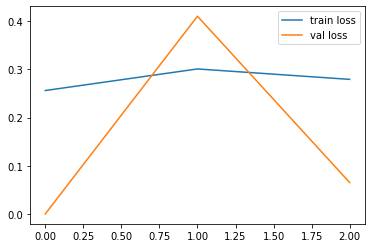

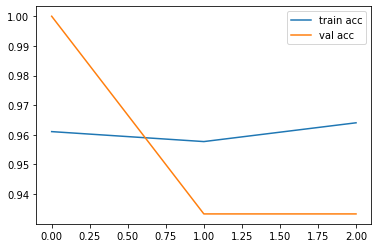

<Figure size 432x288 with 0 Axes>

In [53]:
# plot graph for the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot graph for the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)
dataset = datasets.ImageFolder(train_path, transform=transform)

In [ ]:
transform_index_to_disease = dataset.class_to_idx

In [ ]:
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)

In [ ]:
y_pred = new_model.predict(test_set)
new_model.make_predict_function

<bound method Model.make_predict_function of <keras.engine.functional.Functional object at 0x7f693ccb7050>>

In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Transforming predicted value to its original disease name
print("Following diseases are detected in predicted image dataset: -")
for x in y_pred:
  print(transform_index_to_disease[x])

Following diseases are detected in predicted image dataset: -
Apple___healthy
Apple___healthy
Apple___Black_rot
Apple___Black_rot
Apple___Black_rot
Apple___Black_rot
Apple___healthy
Apple___Cedar_apple_rust
Apple___healthy
Apple___Apple_scab
Apple___Apple_scab
Apple___Cedar_apple_rust
Apple___Apple_scab
Apple___Cedar_apple_rust
Apple___Black_rot
Apple___Cedar_apple_rust
Apple___Black_rot
Apple___Apple_scab
Apple___Apple_scab
Apple___healthy
Apple___Black_rot
Apple___Apple_scab
Apple___healthy
Apple___Cedar_apple_rust
Apple___healthy
Apple___Cedar_apple_rust
Apple___healthy


**Displaying whether apple leaf image is healthy** **or** **diseased** 

Disease detection for 27 apple leaf images is as follows...


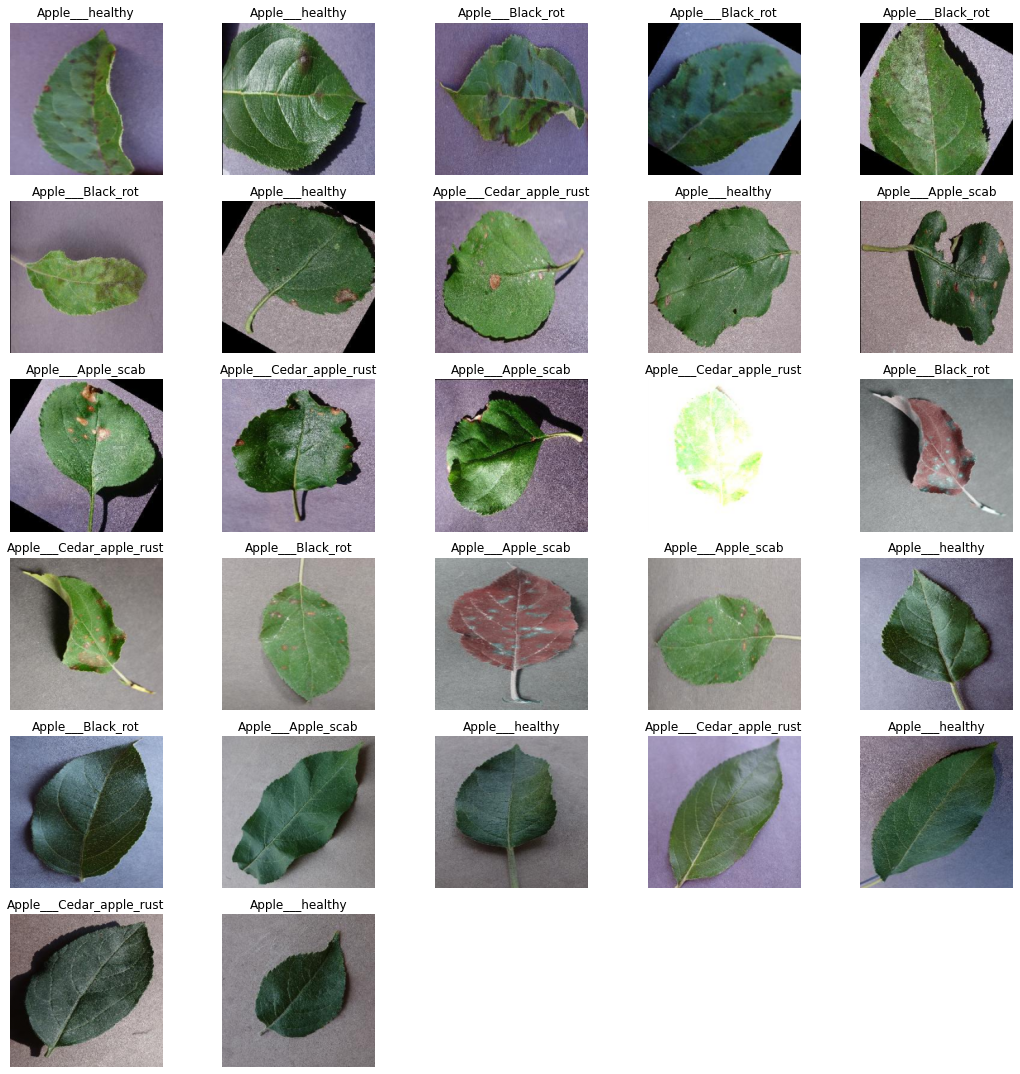

In [ ]:
image_paths = glob.glob("/content/drive/MyDrive/Computer_Vision/Apple_Leaf_Disease_Detection_DS/test/test/*.JPG")
print("Disease detection for %i apple leaf images is as follows..."%(len(image_paths)))
fig = plt.figure(figsize=(15,15))
cols = 5
rows = 6
fig_list = []

for i in range(cols*rows):
  if i < len(image_paths):
    fig_list.append(fig.add_subplot(rows,cols,i+1))
    fig_list[-1].set_title(transform_index_to_disease[y_pred[i]]) # classify disease for each image
    img = preprocess_image(image_paths[i],True)
    plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()